In [ ]:
!pip install torchgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchgan.layers import MinibatchDiscrimination1d 
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from tqdm.notebook import trange
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch import optim
from torch.autograd import Variable 
from torch.utils import data
import time as time
import numpy as np
from IPython import display

import h5py 
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

from torch.nn.modules.activation import LeakyReLU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
class Normalize01(transforms.Normalize):
    """Normalize between 0 and 1"""
    def __init__(self, feature_min, feature_max):
        self.min = torch.tensor(feature_min, dtype=torch.float32)
        self.range = torch.tensor(feature_max, dtype=torch.float32) - self.min

    def __call__(self, tensor):
        return (((tensor - self.min) / self.range)-0.5)*2
    
class RotationTransform():
    """Rotate by 90 degrees."""

    def __init__(self):
        self.angle = 90

    def __call__(self, x):
        #angle = random.choice(self.angles)
        return TF.rotate(x, self.angle)

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        Normalize01(4503.0474,7507.9136),
        #transforms.Normalize(0.5,0.5)
        #RotationTransform()
        ])

In [ ]:
class HDF5Dataset(Dataset):
               
    def __init__(self, h5_path,transform = None):
        self.h5_path = h5_path
        f = h5py.File(h5_path, 'r')
        self.mDoppler = f['mDoppler'][:,:,:].astype('float32')#[:,:60,32:-33]#
        self.label = np.array(f['labels'], dtype='str')
        self.length = len(self.label)
        self.transform = transform
        self.labels_dict = {'fall on floor of room': 0, 'get in  bed': 1,
                   'get out  bed': 2, 'lie in bed': 3,
                   'roll in bed': 4, 'sit down on bed': 5,
                   'sit down on chair': 6, 'sit in bed': 7,
                   'stand up from bed': 8, 'stand up from chair': 9,
                   'stand up from floor of room': 10, 'walk to bed': 11,
                   'walk to chair': 12, 'walk to room': 13}

    def __getitem__(self, index): #to enable indexing
        
        doppler = (self.mDoppler[index])
        label = self.label[index]
        numerical_label = self.labels_dict[label]
        
        if self.transform:
            doppler = self.transform(doppler)
        
        return (doppler,label,numerical_label)

    def __len__(self):
        return self.length

In [ ]:
train_dataset = HDF5Dataset('/content/drive/MyDrive/PatientActivityRecognition/provadolce.h5',transform=transform)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)

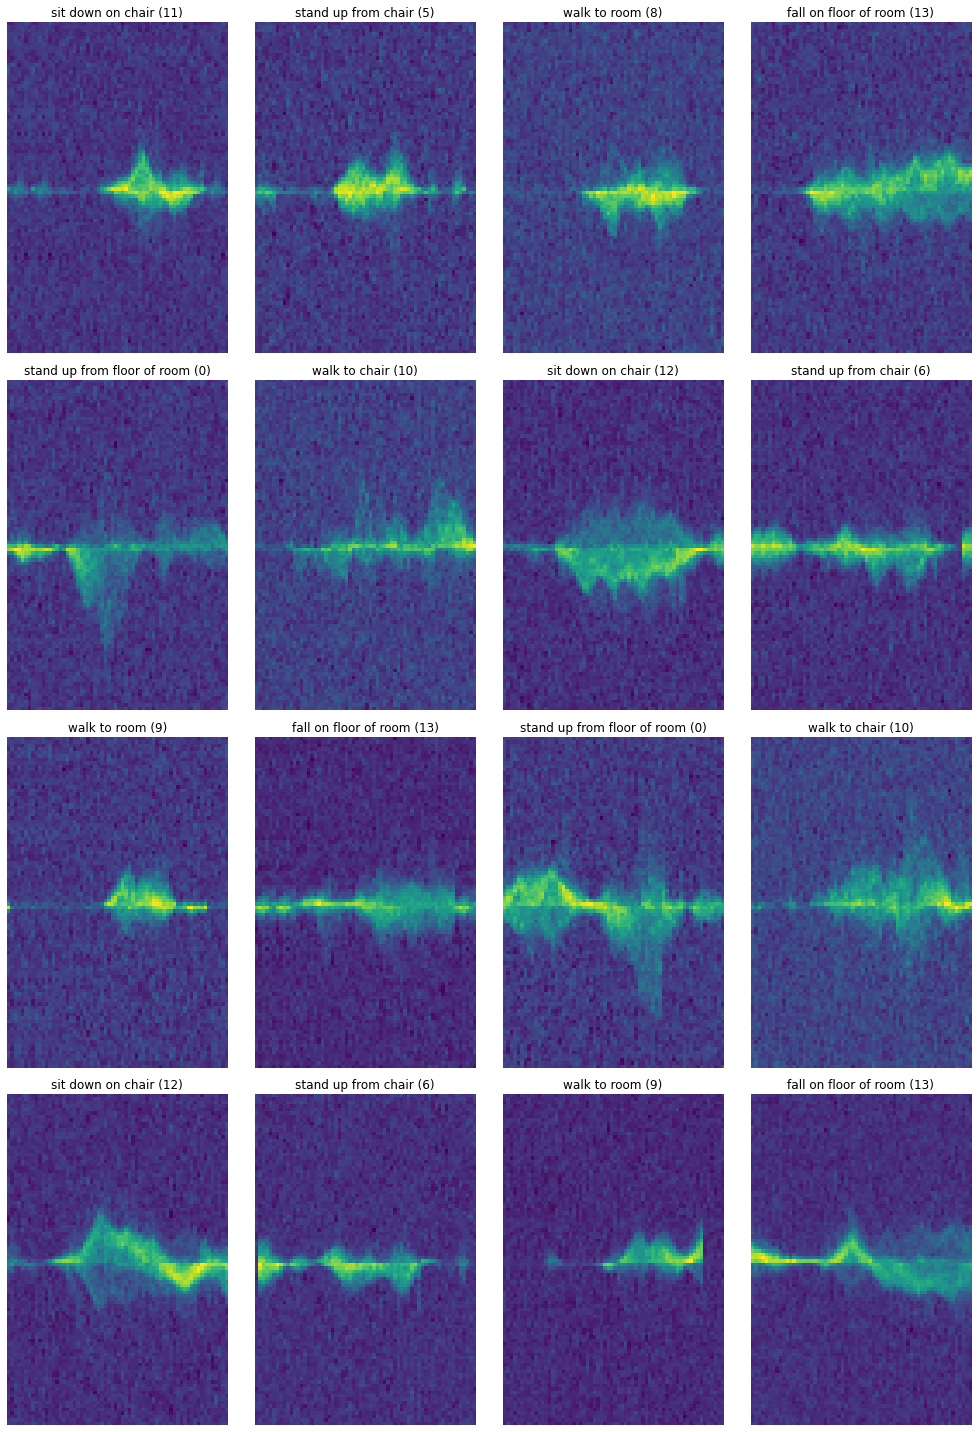

In [ ]:
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(14,20))
for i in range(0,16):
    ax[i//4,i%4].imshow(train_dataset[i][0].squeeze())
    ax[i//4,i%4].set_title(train_dataset[i+400][1].squeeze()+ " ({})".format(np.array(train_dataset[i][2])),
                           fontsize=12)
    ax[i//4,i%4].axis('off')
plt.tight_layout();

In [ ]:
class MiniBatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dim):
        """ - in_features = A
            - out_features = B
            - kernel_dim = C"""
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dim = kernel_dim
        
        self.T = nn.Parameter(torch.Tensor(self.in_features,self.out_features,self.kernel_dim))
        nn.init.normal_(self.T,0,1)
        
    def forward(self,x):
        """ - x = minibatch with dimension nxA
            - T = tensor with dimension AxBXC
        """
        
        M = x.mm(self.T.reshape(self.in_features,self.out_features*self.kernel_dim)) # Nx(B*C)
        M = M.reshape(-1,self.out_features,self.kernel_dim) # NxBxC
        M = M.unsqueeze(0) # 1xNxBxC
        MT = M.permute(1, 0, 2, 3)  # Nx1xBxC
        norm = torch.abs(M - MT).sum(3)  # NxNxB
        expnorm = torch.exp(-norm)
        o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance
        y = torch.cat([x, o_b], 1)
        return y

In [ ]:
"""class Generator(nn.Module):
  def __init__(self,z_size,embedding_dim=14):

    super().__init__()

    self.input_size = z_size

    self.label_embedding = nn.Sequential(
        nn.Embedding(14,embedding_dim),
        nn.Linear(embedding_dim,24*16),
        nn.LeakyReLU()
    )
    
    self.label_embedding2 = nn.Sequential(
        nn.Embedding(14,embedding_dim),
        nn.Linear(embedding_dim,96*64),
        nn.LeakyReLU()
    )

    self.fc_net = nn.Sequential(
        nn.Linear(self.input_size, 24*16*2, bias=False),
        nn.BatchNorm1d(24*16*2),
        nn.LeakyReLU(),
        nn.Linear(24*16*2, 24*16*32, bias=False),
        nn.BatchNorm1d(24*16*32),
        nn.LeakyReLU(),
    )
    
    self.conv_model = nn.Sequential(
        
        # Block 1: Going from z to a 64x8 channels input
        #nn.ConvTranspose2d(33, 33, (9,9), bias=False, padding=(4,4), stride=1, output_padding=0),
        #nn.BatchNorm2d(33),
        #nn.LeakyReLU(),
        #nn.Dropout(0.15),
        
        nn.ConvTranspose2d(33, 16, (5,5), bias=False, padding=(2,2), stride=2, output_padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.15),
        # Dim: 64x8x(4x3)
        
        
        #Block 2: 64x8x(4x6) --> 64x4x(8x12)
        nn.ConvTranspose2d(16, 1, (5,5), bias=False, padding=(2,2), stride=2, output_padding=1),
        nn.BatchNorm2d(1),
        nn.ReLU(),
        nn.Dropout(0.15)
        
    )
    
    self.conv2_model = nn.Sequential(
        
        nn.ConvTranspose2d(1, 1, (5,5), bias=False, padding=(2,2), stride=1, output_padding=0),
        nn.Dropout(0.15),
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 1, (3,3), bias=False, padding=(1,1), stride=1),
        nn.Tanh(),
    )

  def forward(self, x, labels):
    embedded_labels = self.label_embedding(labels.reshape(-1,1)).reshape((-1,1,24,16))
    latent = self.fc_net(x)
    latent = latent.reshape((-1, 32, 24, 16))
    y = torch.cat((latent, embedded_labels), dim=1)
    y = self.conv_model(y)
    embedded2_labels = self.label_embedding2(labels.reshape(-1,1)).reshape((-1,1,96,64))
    y = torch.add(y, embedded2_labels)
    y = self.conv2_model(y)
    return y"""

'class Generator(nn.Module):\n  def __init__(self,z_size,embedding_dim=14):\n\n    super().__init__()\n\n    self.input_size = z_size\n\n    self.label_embedding = nn.Sequential(\n        nn.Embedding(14,embedding_dim),\n        nn.Linear(embedding_dim,24*16),\n        nn.LeakyReLU()\n    )\n    \n    self.label_embedding2 = nn.Sequential(\n        nn.Embedding(14,embedding_dim),\n        nn.Linear(embedding_dim,96*64),\n        nn.LeakyReLU()\n    )\n\n    self.fc_net = nn.Sequential(\n        nn.Linear(self.input_size, 24*16*2, bias=False),\n        nn.BatchNorm1d(24*16*2),\n        nn.LeakyReLU(),\n        nn.Linear(24*16*2, 24*16*32, bias=False),\n        nn.BatchNorm1d(24*16*32),\n        nn.LeakyReLU(),\n    )\n    \n    self.conv_model = nn.Sequential(\n        \n        # Block 1: Going from z to a 64x8 channels input\n        #nn.ConvTranspose2d(33, 33, (9,9), bias=False, padding=(4,4), stride=1, output_padding=0),\n        #nn.BatchNorm2d(33),\n        #nn.LeakyReLU(),\n     

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_size,embedding_dimension=14):
    super().__init__()

    self.label_embedding = nn.Sequential(
        nn.Embedding(14,embedding_dimension),
        nn.Linear(14,48*32),
        nn.BatchNorm1d(48*32),
        nn.LeakyReLU(0.2),
        nn.Linear(48*32,96*64),
        nn.LeakyReLU(0.3)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(z_size, 64*2*8*12, bias=False),
        nn.BatchNorm1d(64*2*8*12),
        nn.LeakyReLU(0.2),
    )

    self.conv_block1 = nn.Sequential(
        

        # Block 1: 64x(8x12) --> 32x(16x24)
        nn.ConvTranspose2d(64*2, 32*2, (3,3), stride=2, bias=False, padding=(1,1),output_padding=1),
        nn.BatchNorm2d(32*2, momentum= 0.4),
        nn.ReLU(),
        nn.Dropout(0.15),


        # Block 1: 32x(16x24) --> 16x(32x48)
        nn.ConvTranspose2d(32*2, 16*2, (3,3), stride=2, bias=False, padding=(1,1), output_padding=1),
        nn.BatchNorm2d(16*2,momentum= 0.4),
        nn.ReLU(),
        nn.Dropout(0.15),
        # Dim: 64x4x(8x12)

        # Block 2: 16x(32x48) --> 1x(64x96)
        nn.ConvTranspose2d(16*2, 8*2, (3,3), stride=2, bias=False, padding=(1,1), output_padding=1),
        nn.BatchNorm2d(8*2,momentum= 0.4),
        nn.ReLU(),
        nn.Dropout(0.15),
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(8*2, 8*2, (5,5), bias=False, padding=(2,2)),
        nn.BatchNorm2d(8*2,momentum= 0.4),
        nn.ReLU(),
        nn.ConvTranspose2d(8*2, 1, (3,3), bias=False, padding=(1,1)),
      
        nn.Tanh()
    )


  def forward(self, x, labels):
      embedded_labels = self.label_embedding(labels).reshape(-1,1,96,64)
      latent = self.fc_model(x)
      latent = latent.reshape((-1, 64*2, 12, 8))
      y = self.conv_block1(latent)
      y = torch.add(y,embedded_labels)
      y = self.conv_block2(y)
      return y

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, embedding_dim=14):

        super().__init__()

        self.label_embedding = nn.Sequential(
            nn.Embedding(14,14),
            nn.Linear(embedding_dim,64*96),
            nn.LeakyReLU()
        )

        self.model = nn.Sequential(
            
            #Block1: 2x(64x96) --> 64x1x(48x32)
            nn.Conv2d(2, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            #Dim: 64x1x(32x48)
            
            #Block2: 64x1x(48x32) --> 32x(24x16)
            nn.Conv2d(32,64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            #Dim: 32x6x4

            #Block1: 2x(64x96) --> 64x1x(48x32)
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            #Dim: 64x1x(32x48)



            nn.Flatten(),

            MinibatchDiscrimination1d(64*12*8,14,12*8),

            nn.Linear(64*12*8+14, 1)
            nn.Dropout(0.4)
            
        )
        

    def forward(self, x, labels):
        embedded_labels = self.label_embedding(labels).reshape((-1,1,96,64))
        #print(x.shape,embedded_labels.shape)
        y = torch.cat((x, embedded_labels), dim=1)
        y = self.model(y)
        return y

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator(100)
generator.apply(weights_init)
generator.to(device)

Generator(
  (label_embedding): Sequential(
    (0): Embedding(14, 14)
    (1): Linear(in_features=14, out_features=1536, bias=True)
    (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=1536, out_features=6144, bias=True)
    (5): LeakyReLU(negative_slope=0.3)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=100, out_features=12288, bias=False)
    (1): BatchNorm1d(12288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.15, inplace=False)
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), out

In [ ]:
discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (label_embedding): Sequential(
    (0): Embedding(14, 14)
    (1): Linear(in_features=14, out_features=6144, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.15, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): MinibatchDi

torch.Size([16, 1, 96, 64])


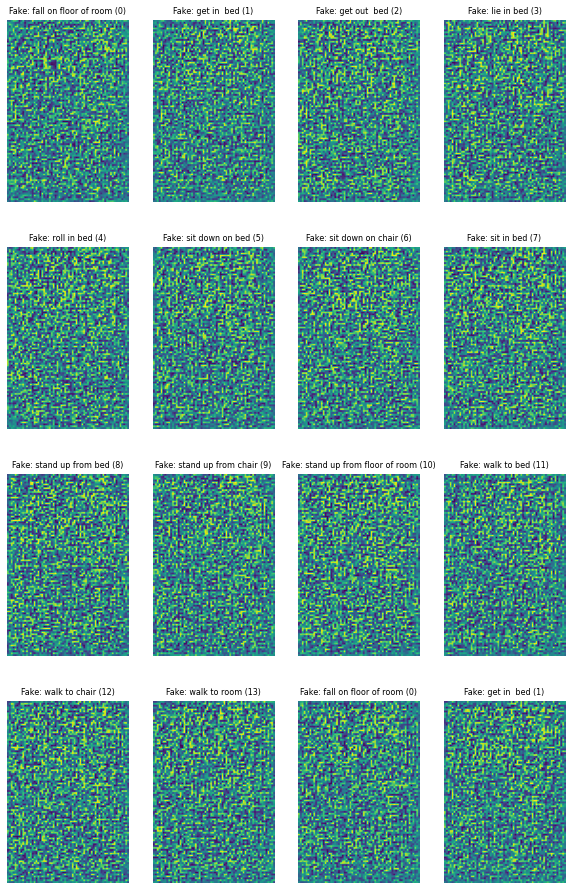

In [ ]:
noise_fix = torch.randn([1, 100], device=device)
#label_fix = torch.full(16,1)
for i in range(4):
  noise_fix = torch.cat([noise_fix,noise_fix],0)

labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,0,1])
generated_image = generator(noise_fix,labels.to(device)).detach()
labels_list = list(train_dataset.labels_dict.keys())
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(10,16))
print(generated_image.shape)
for i in range(0,16):
    ax[i//4,i%4].imshow(generated_image.cpu().squeeze()[i],cmap='viridis')
    ax[i//4,i%4].set_title('Fake: '+ labels_list[np.array(labels[i])]+ " ({})".format(np.array(labels[i])),
                           fontsize=8)
    ax[i//4,i%4].axis('off')

    #plt.tight_layout();
#fig = plt.figure()
#plt.imshow(train_dataset[100][0].squeeze(),cmap='viridis')
#plt.title(train_dataset[100][1]+': '+str(train_dataset[100][2]));

In [ ]:
decision = discriminator(generated_image,labels.to(device)).detach()
print(decision)

tensor([[ 0.5217],
        [ 0.4240],
        [ 0.3552],
        [ 0.5003],
        [ 0.6829],
        [ 0.8332],
        [ 0.7210],
        [ 0.6037],
        [ 1.3200],
        [ 1.5734],
        [ 1.2470],
        [ 1.0503],
        [ 0.7166],
        [-1.4432],
        [-0.0746],
        [ 0.4377]], device='cuda:0')


In [ ]:
cross_entropy = nn.BCEWithLogitsLoss()
def discriminator_loss(real_output, fake_output, device,alpha=0.1):

    real_loss = cross_entropy(real_output, torch.full_like(real_output, 1-alpha, device=device))
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output, device):
    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))

    return gen_loss

In [ ]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5,0.999))
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=0.5e-4, betas=(0.5,0.999))

In [ ]:
seed = torch.randn([1, 100], device=device)
#label_fix = torch.full(16,1)
for i in range(4):
  seed = torch.cat([seed,seed],0)
noise_dim = 100
#num_examples_to_generate = 16
#seed = torch.randn([num_examples_to_generate, noise_dim], device=device)
test_labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,0,1],device=device)

In [ ]:
def train_step(microdoppler, labels, generator, discriminator, batch_size, batch_number, len_dataset,
               noise_dim, device, dis_opt, gen_opt, epoch,k=1):
    
    if k==1:
        if batch_number<len_dataset//batch_size:
                noise = torch.randn([batch_size,noise_dim], device=device)
                fake_labels = torch.randint(14,[batch_size,], device=device)
        else:
            noise = torch.randn([len_dataset%batch_size, noise_dim], device=device)
            fake_labels = torch.randint(14,[len_dataset%batch_size,], device=device)

        generated_microdoppler = generator(noise,fake_labels)

        #discriminator_detractor = (torch.tanh(torch.randn([96,64]))/(1+0.1*epoch)).to(device)
        #real_output = discriminator(torch.add(microdoppler,discriminator_detractor),labels)
        #fake_output = discriminator(torch.add(generated_microdoppler.detach(),discriminator_detractor),fake_labels.detach())

        real_output = discriminator(microdoppler,labels)
        fake_output = discriminator(generated_microdoppler.detach(),fake_labels.detach())

        disc_loss = discriminator_loss(real_output, fake_output, device)
        dis_opt.zero_grad()
        disc_loss.backward()
        dis_opt.step()

        fake_output = discriminator(generated_microdoppler,fake_labels)
        gen_loss = generator_loss(fake_output, device)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        
        return gen_loss, disc_loss
    
    else:
        
        for step in range(k):

            if batch_number<len_dataset//batch_size:
                noise = torch.rand([batch_size,noise_dim], device=device)
                fake_labels = torch.randint(14,[batch_size,], device=device)
            else:
                noise = torch.rand([len_dataset%batch_size, noise_dim], device=device)
                fake_labels = torch.randint(14,[len_dataset%batch_size,], device=device)

            generated_microdoppler = generator(noise,fake_labels).detach()

            real_output = discriminator(microdoppler,labels)
            fake_output = discriminator(generated_microdoppler,fake_labels)

            disc_loss = discriminator_loss(real_output,fake_output, device)
            dis_opt.zero_grad()
            disc_loss.backward()
            dis_opt.step()


        if batch_number<len_dataset//batch_size:
                noise = torch.rand([batch_size,noise_dim], device=device)
                fake_labels = torch.randint(14,[batch_size,], device=device)
        else:
            noise = torch.rand([len_dataset%batch_size, noise_dim], device=device)
            fake_labels = torch.randint(14,[len_dataset%batch_size,], device=device)

        generated_microdoppler = generator(noise,fake_labels)

        fake_output = discriminator(generated_microdoppler,fake_labels)
        gen_loss = generator_loss(fake_output,device)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model,epoch,test_input,test_label,labels_list):
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_input,test_labels).detach().cpu()
    
    fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(10,16))
    for i in range(0,16):
        ax[i//4,i%4].imshow(predictions.numpy().squeeze().transpose(1,2,0)[:,:,i])
        ax[i//4,i%4].set_title('Fake: '+ labels_list[np.array(test_label[i].cpu())]+ " ({})".format(np.array(test_label[i].cpu())),
                               fontsize=8)
        ax[i//4,i%4].axis('off')
    plt.tight_layout()
    if (epoch % 100) ==0:
      plt.savefig("/content/drive/MyDrive/PatientActivityRecognition/CGAN2_{}_epochs.png".format(epoch),format="png")
    plt.show()
    model.train()

In [ ]:
def train(dataloader, epochs, generator, discriminator, BATCH_SIZE, len_dataset, noise_dim, device, dis_opt, gen_opt):
    #fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(10,16))
    #fig1,ax1 = plt.subplots(figsize=(10,6.7))
    gloss = []
    dloss = []
    for epoch in range(epochs):
        start = time.time()

        gen_losses = []
        disc_losses = []
        i=0
        for image_batch, _, labels in dataloader:
            image_batch = image_batch.to(device)
            labels = labels.to(device)
            gen_loss, disc_loss = train_step(image_batch, labels, generator, discriminator, BATCH_SIZE, i, len_dataset, noise_dim, device, dis_opt, gen_opt,epoch)
            gen_losses.append(gen_loss.detach().cpu())
            disc_losses.append(disc_loss.detach().cpu())
            i+=1
            #print(i)

        gloss.append(np.mean(gen_losses))
        dloss.append(np.mean(disc_losses))
        #Produce images
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 test_labels,
                                 labels_list
                                 )
        
        fig = plt.figure(figsize=(10,6.7))
        plt.plot(np.arange(len(gloss)),gloss,label="Generator Loss")
        plt.plot(np.arange(len(dloss)),dloss,label="Discriminator Loss")
        plt.legend(loc='best')
        plt.grid(ls='--');

        if (epoch+1)%100==0:
          plt.savefig("/content/drive/MyDrive/PatientActivityRecognition/Loss_CGAN2_{}_epochs.png".format(epoch+1), format="png")
        

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        if (epoch+1)%100==0:
          torch.save({
            'epoch': epoch+1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'gen_optimizer_state_dict': gen_opt.state_dict(),
            'dis_optimizer_state_dict': dis_opt.state_dict(),
            'gloss': gloss,
            'dloss': dloss,
            }, "/content/drive/MyDrive/PatientActivityRecognition/CGAN2_{}_epochs_checkpoint.pt".format(epoch+1))
        
        

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed,
                           test_labels,
                           labels_list
                           )
    return gloss, dloss

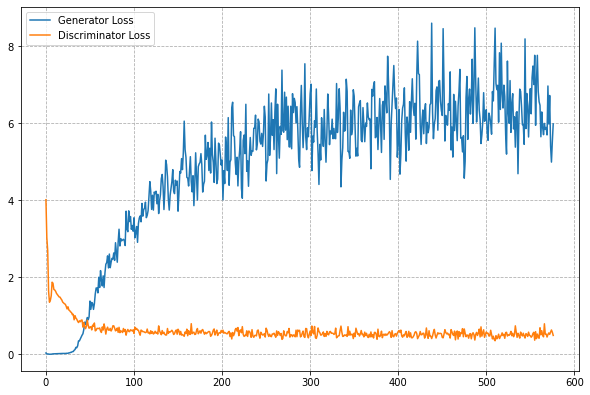

In [ ]:
EPOCHS = 5000
generator.to(device)
discriminator.to(device)
gloss, dloss = train(train_loader, EPOCHS, generator, discriminator, BATCH_SIZE, len(train_dataset),
                     noise_dim, device, dis_opt, gen_opt)

In [ ]:
noise= torch.randn([16, 100], device=device)
#label_fix = torch.full(16,1)
#for i in range(4):
  #noise_fix = torch.cat([noise_fix,noise_fix],0)

#labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,0,1])
labels = torch.tensor([0,0,0,0,2,2,2,2,4,4,4,4,6,6,6,6])
generated_image = generator(noise,labels.to(device)).detach()
labels_list = list(train_dataset.labels_dict.keys())
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(10,16))
print(generated_image.shape)
for i in range(0,16):
    ax[i//4,i%4].imshow(generated_image.cpu().squeeze()[i],cmap='viridis')
    ax[i//4,i%4].set_title('Fake: '+ labels_list[np.array(labels[i])]+ " ({})".format(np.array(labels[i])),
                           fontsize=8)
    ax[i//4,i%4].axis('off')

    #plt.tight_layout();
#fig = plt.figure()
#plt.imshow(train_dataset[100][0].squeeze(),cmap='viridis')
#plt.title(train_dataset[100][1]+': '+str(train_dataset[100][2]));